In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

In [8]:
"""
Fixed parameters
"""

block_size = None  # Number of detections in key generating basis
total_bit_sequence_length = 13600000000  # Transmittance in Bob’s side, including internal transmittance of optical components and detector efficiency
eta_bob = 4.5 / 100  # t_Bob * eta_D
y_0 = 1.7e-6  # Background rate, which includes the detector dark count and other background contributions such as the stray light from timing pulses
channel_attenuation_Z = 26  # Channel transmittance [dB], can be derived from the loss coefficient alpha measured in dB/km and the length of the fiber l in km, alpha = 0.21
channel_attenuation_X = 26
q_Z = 0.5  # Bob chooses a basis Z and X with probabilities qz
e_detector_Z = (
    3.3 / 100
)  # e_detector, characterizes the alignment and stability, characterizes the alignment and stability, assume constant
e_detector_X = 3.3 / 100
e_0 = 1 / 2  # error rate of the background, will assume that the background is random
epsilon_sec = 1e-10  # It's called a "epsilon_sec-secret"
epsilon_cor = 1e-15  # Secret key are identical except of probability epsilon_cor
repetition_rate = 1e9  # Pulse (symbol) repetition rate
fEC = 1.22  # Error correction effciency
epsilon_1 = epsilon_sec / 19
total_time = 0


# Entropy function
def entropy(p):
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)


# Finite key correction
def n_finite_key_corrected(sign, k, p_k, n_k, n, epsilon):
    if sign == "+":
        return np.exp(k) / p_k * (n_k + np.sqrt(n / 2 * np.log(1 / epsilon)))
    elif sign == "-":
        return np.exp(k) / p_k * (n_k - np.sqrt(n / 2 * np.log(1 / epsilon)))
    else:
        raise ValueError("Invalid sign value. Must be '+' or '-'.")


# Gamma function
def gamma(a, b, c, d):
    return np.sqrt(
        (c + d)
        * (1 - b)
        * b
        / (c * d * np.log(2))
        * np.log((c + d) * 21**2 / (c * d * (1 - b) * a**2))
    )


def calculate_skr(params):
    mus, mud, p_mus, p_Z = params
    p_mud = 1 - p_mus
    p_X = 1 - p_Z
    q_X = 1 - q_Z
    global total_bit_sequence_length

    # Compute gain
    eta_ch_Z = np.power(10, -channel_attenuation_Z / 10)
    eta_ch_X = np.power(10, -channel_attenuation_X / 10)
    gain_Z_mus = 1 - (1 - y_0) * np.exp(-1 * mus * eta_bob * eta_ch_Z)
    gain_Z_mud = 1 - (1 - y_0) * np.exp(-1 * mud * eta_bob * eta_ch_Z)
    gain_X_mus = 1 - (1 - y_0) * np.exp(-1 * mus * eta_bob * eta_ch_X)
    gain_X_mud = 1 - (1 - y_0) * np.exp(-1 * mud * eta_bob * eta_ch_X)

    # Recalucalte total_bit_sequence_length to match desired nZ
    if block_size is not None:
        total_bit_sequence_length = block_size / (
            p_Z * (p_mus * gain_Z_mus + p_mud * gain_Z_mud)
        )

    # Compute total detection events
    # n_Z_mus = p_Z * q_Z * p_mus * gain_Z_mus * total_bit_sequence_length
    # n_Z_mud = p_Z * q_Z * p_mud * gain_Z_mud * total_bit_sequence_length
    # n_X_mus = p_X * q_X * p_mus * gain_X_mus * total_bit_sequence_length
    # n_X_mud = p_X * q_X * p_mud * gain_X_mud * total_bit_sequence_length
    # n_Z = n_Z_mus + n_Z_mud
    # n_X = n_X_mus + n_X_mud

    n_Z_mus = 38826000
    n_Z_mud = 692000
    n_X_mus = 184000
    n_X_mud = 0
    n_Z = n_Z_mus + n_Z_mud
    n_X = n_X_mus + n_X_mud

    # Compute error
    # error_Z_mus = y_0 * (e_0 - e_detector_Z) + e_detector_Z * gain_Z_mus
    # error_Z_mud = y_0 * (e_0 - e_detector_Z) + e_detector_Z * gain_Z_mud
    # error_X_mus = y_0 * (e_0 - e_detector_X) + e_detector_X * gain_X_mus
    # error_X_mud = y_0 * (e_0 - e_detector_X) + e_detector_X * gain_X_mud

    error_Z_mus = 40000
    error_Z_mud = 10000
    error_X_mus = 7000
    error_X_mud = 0

    # # Compute total error events
    m_Z_mus = p_Z * q_Z * p_mus * error_Z_mus * total_bit_sequence_length
    m_Z_mud = p_Z * q_Z * p_mud * error_Z_mud * total_bit_sequence_length
    m_X_mus = p_X * p_X * p_mus * error_X_mus * total_bit_sequence_length
    m_X_mud = p_X * p_X * p_mud * error_X_mud * total_bit_sequence_length
    m_Z = m_Z_mus + m_Z_mud
    m_X = m_X_mus + m_X_mud

    # Probabilites sending vaccum and single photon states
    tau_0 = p_mus * np.exp(-mus) + p_mud * np.exp(-mud)
    tau_1 = p_mus * mus * np.exp(-mus) + p_mud * mud * np.exp(-mud)

    # Compute finite-key security bounds
    s_l_Z0 = (
        tau_0
        / (mus - mud)
        * (
            mus * n_finite_key_corrected("-", mud, p_mud, n_Z_mud, n_Z, epsilon_1)
            - mud * n_finite_key_corrected("+", mus, p_mus, n_Z_mus, n_Z, epsilon_1)
        )
    )
    s_u_Z0 = 2 * (
        tau_0 * n_finite_key_corrected("+", mus, p_mus, m_Z_mus, m_Z, epsilon_1)
        + np.sqrt(n_Z / 2 * np.log(1 / epsilon_1))
    )
    s_l_Z1 = (
        tau_1
        * mus
        / (mud * (mus - mud))
        * (
            n_finite_key_corrected("-", mud, p_mud, n_Z_mud, n_Z, epsilon_1)
            - mud**2
            / mus**2
            * n_finite_key_corrected("+", mus, p_mus, n_Z_mus, n_Z, epsilon_1)
            - (mus**2 - mud**2) / (mus**2 * tau_0) * s_u_Z0
        )
    )
    s_u_X0 = 2 * (
        tau_0 * n_finite_key_corrected("+", mud, p_mud, m_X_mud, m_X, epsilon_1)
        + np.sqrt(n_X / 2 * np.log(1 / epsilon_1))
    )
    s_l_X1 = (
        tau_1
        * mus
        / (mud * (mus - mud))
        * (
            n_finite_key_corrected("-", mud, p_mud, n_X_mud, n_X, epsilon_1)
            - mud**2
            / mus**2
            * n_finite_key_corrected("+", mus, p_mus, n_X_mus, n_X, epsilon_1)
            - (mus**2 - mud**2) / (mus**2 * tau_0) * s_u_X0
        )
    )
    v_u_X1 = (
        tau_1
        / (mus - mud)
        * (
            n_finite_key_corrected("+", mus, p_mus, m_X_mus, m_X, epsilon_1)
            - n_finite_key_corrected("-", mud, p_mud, m_X_mud, m_X, epsilon_1)
        )
    )
    phi_u_Z1 = v_u_X1 / s_l_X1 * gamma(epsilon_sec, v_u_X1 / s_l_X1, s_l_Z1, s_l_X1)

    # Error correction term
    lambda_EC = n_Z * fEC * entropy(m_Z / n_Z)

    # Compute secret key length
    secret_key_length = (
        s_l_Z0
        + s_l_Z1 * (1 - entropy(phi_u_Z1))
        - lambda_EC
        - 6 * np.log2(19 / epsilon_sec)
        - np.log2(2 / epsilon_cor)
    )
    SKR = repetition_rate * secret_key_length / total_bit_sequence_length

    # Set time it takes
    global total_time
    total_time = total_bit_sequence_length / repetition_rate

    return -SKR  # Negative for minimization

C:\Users\leavi\AppData\Local\Temp\ipykernel_25240\3660375547.py:47: RuntimeWarning: invalid value encountered in log
  * np.log((c + d) * 21**2 / (c * d * (1 - b) * a**2))
C:\Users\leavi\AppData\Local\Temp\ipykernel_25240\3660375547.py:27: RuntimeWarning: invalid value encountered in log2
  return -p * np.log2(p) - (1 - p) * np.log2(1 - p)


Optimization failed: Maximum number of function evaluations has been exceeded.
Optimization failed: Maximum number of function evaluations has been exceeded.
Optimization failed: Maximum number of function evaluations has been exceeded.
Optimization failed: Maximum number of function evaluations has been exceeded.
Optimization failed: Maximum number of function evaluations has been exceeded.
Optimization failed: Maximum number of function evaluations has been exceeded.
Optimization failed: Maximum number of function evaluations has been exceeded.
Optimization failed: Maximum number of function evaluations has been exceeded.
Optimization failed: Maximum number of function evaluations has been exceeded.
Optimization failed: Maximum number of function evaluations has been exceeded.
Optimization failed: Maximum number of function evaluations has been exceeded.
Optimization failed: Maximum number of function evaluations has been exceeded.
Optimization failed: Maximum number of function eval

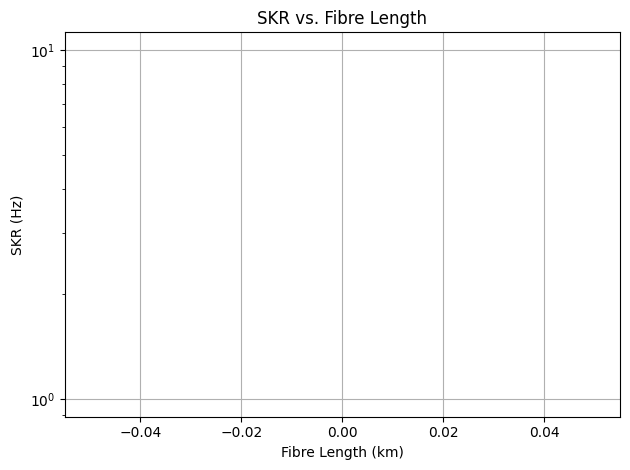

In [9]:
"""
Parameter Optimization
"""

initial_params = [0.5, 0.5 / 2, 0.7, 0.9]  # mus, mud, p_mus, p_Z
bounds = [(0.001, 1), (0.001, 1), (0, 1), (0, 1)]  # bounds

fibre_length = np.linspace(0, 110, num=100)
attenuations = 0.21 * fibre_length
optimized_skr_values = []  # Store the optimized SKR values

for attenuation in attenuations:
    channel_attenuation_Z = attenuation
    channel_attenuation_X = attenuation
    result = scipy.optimize.minimize(
        calculate_skr, initial_params, bounds=bounds, method="Nelder-Mead"
    )
    if result.success:
        optimized_params = result.x
        optimized_skr = -result.fun
        optimized_skr_values.append(optimized_skr / repetition_rate)
    else:
        print("Optimization failed:", result.message)
        optimized_skr_values.append(np.nan)

optimized_skr_values = np.array(optimized_skr_values)

# Plotting with a logarithmic y-axis
plt.plot(fibre_length, optimized_skr_values)
plt.xlabel("Fibre Length (km)")
plt.ylabel("SKR (Hz)")
plt.title("SKR vs. Fibre Length")
plt.yscale("log")
plt.grid(True)  #
plt.tight_layout()
plt.savefig("skr_over_distance", dpi=300)
plt.show()